In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
from sklearn.linear_model import SGDRegressor
import time
from sklearn.preprocessing import  StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error
from alpha_vantage.timeseries import TimeSeries
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_diabetes


#ts = TimeSeries(key='AAPL', output_format='pandas')
#data, meta_data = ts.get_intraday(symbol='MSFT',interval='60min', outputsize='full')

# Define the list of top 100 company tickers, use only AAPL for now
tickers = ['AAPL']

# Set the date range
start_date = '2002-11-06'
end_date = datetime.today().strftime('%Y-%m-%d')

# Loop through each ticker and download data
for ticker in tickers:
    # Download historical data
    data = yf.download(ticker, start=start_date, end=end_date)
    # Reset column names to avoid mismatched headers
    data.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
    # Reset the index to a new "Date" column and keep only the date part
    data.reset_index(inplace=True)
    data['Date'] = data['Date'].dt.date  # Convert DateTime to just date (YYYY-MM-DD format) to get rid of hours, minutes, and seconds
    data['Date'] = pd.to_datetime(data['Date']) # Convert 'Date' column to datetime format so model interpret it as dates
   

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")


# Separate the 'Date' column (to keep it unchanged)
date_column = data['Date']
data_numeric = data.drop(columns=['Date'])





# incremental process
# pca
Apple = data_numeric
App = Apple.loc[:,['Adj Close', 'Close', 'High','Low', 'Open', 'Volume']]

App = App.to_numpy()





[*********************100%***********************]  1 of 1 completed


In [26]:
# incremental process 


scaleA = StandardScaler()

# transform all columns
App = scaleA.fit_transform(App)

    # initial state
init = 1000
X = App[0:init, [0,2,3,4,5]]
y = App[0:init, [1]]


    # incremental learning 
start = time.time()
SGD1 = SGDRegressor(penalty='elasticnet')


    # initial fit
SGD1.fit(X, np.ravel(y))
initY = SGD1.predict(X)
ypred1 = []
for i in range(App.shape[0] - init):
    X_single = App[init+i, [0,2,3,4,5]]
    X_single = X_single.reshape(1,-1)

    p = SGD1.predict(X_single)
    ypred1.append(p)
    SGD1.partial_fit(X_single, np.ravel(App[init+i, [1]]))
        #SGD1.partial_fit(App[0:init+i, [0,1,2,4]], App[0:init+i, [3]])
end = time.time()

print(end - start)
   
    # traditional 
start = time.time()
SGD2 = SGDRegressor(penalty='elasticnet')
SGD2.fit(X, np.ravel(y))
initY2 = SGD2.predict(X)
ypred2 = []
for i in range(App.shape[0] - init):
    X_single = App[init+i, [0,2,3,4,5]]
    X_single = X_single.reshape(1,-1)

    p = SGD2.predict(X_single)
    ypred2.append(p)
    SGD2.fit(App[0:init+i, [0,2,3,4,5]], np.ravel(App[0:init+i, [1]]))
end = time.time()
print(end - start)


0.3460838794708252
4.5417468547821045


In [27]:
cool = scaleA.inverse_transform(App)
ytrue = cool[:, 1]
ypred1 = np.array(ypred1)
ypred2 = np.array(ypred2)
ypred1 = (ypred1 * ytrue.std()) + ytrue.mean()
ypred2 = (ypred2 * ytrue.std()) + ytrue.mean()


from sklearn.metrics import mean_absolute_error



4.732862471391632
2.202358825854677
2.754497347374759
1.6786569348010763


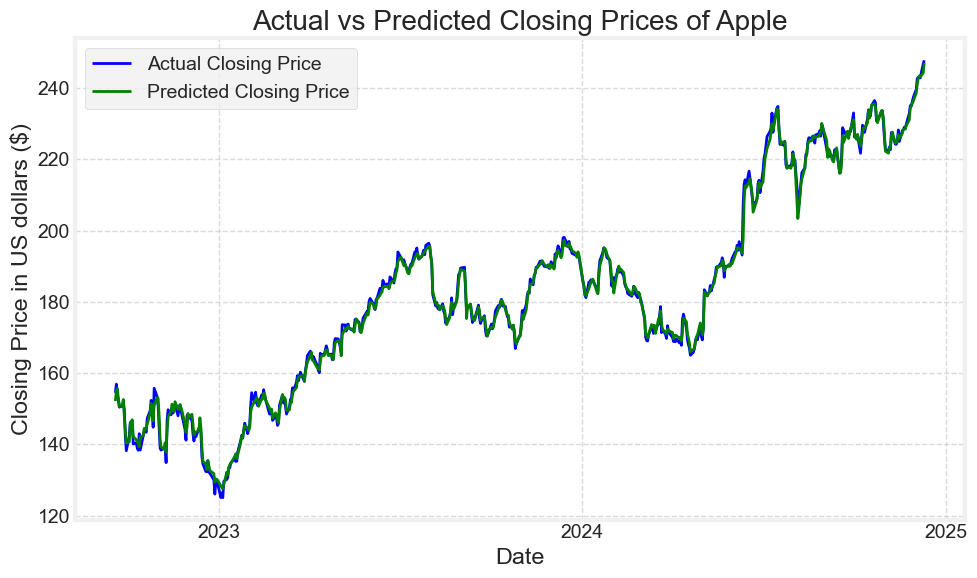

In [28]:
initY = initY.reshape(-1,1)
initY = (initY * ytrue.std()) + ytrue.mean()
initY2 = initY2.reshape(-1,1)
initY2 = (initY2 * ytrue.std()) + ytrue.mean()
ypred1 = np.concatenate((initY, ypred1))
ypred2 = np.concatenate((initY2, ypred2))
Apple['pred'] = ypred1
Apple['pred2'] = ypred2

print(root_mean_squared_error(ypred1, ytrue))
print(root_mean_squared_error(ypred2, ytrue))

print(mean_absolute_error(ypred1, ytrue))
print(mean_absolute_error(ypred2, ytrue))

import matplotlib.dates as mdates


fig = plt.figure(figsize=(10, 6))
fig.patch.set_facecolor('xkcd:white')
plt.plot(date_column[5000:], Apple.loc[5000:,'Close'],label='Actual Closing Price', color='blue', linewidth=2)
plt.plot(date_column[5000:], Apple.loc[5000:, 'pred'],label='Predicted Closing Price', color='green',linewidth=2)
plt.xlabel('Date')
plt.ylabel('Closing Price in US dollars ($)')
plt.title("Actual vs Predicted Closing Prices of Apple")
plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0.7,)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
ax = plt.gca()
ax.set_facecolor('xkcd:white')

plt.show()